In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import csv
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

# for custom functions
import os
import sys
# import sys; sys.path.insert(0, '..')
# from lib.custom_functions import * 

import warnings
warnings.filterwarnings('ignore')

#### Custom Functions
Custom functions for data processing and preparation.

In [2]:

def mean(s: pd.Series):
    return s.mean()

def median(s: pd.Series):
    return s.median()

def drop_features(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    df = df.drop(columns, axis=1)
    return df

def bool_to_binary(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        local_kwargs = {column : lambda df: df[column].astype(str).str.replace('t', '1').replace('f', '0').replace('True', '1').replace('False', '0').astype(int)}

        df = (
            df
            .assign(**local_kwargs)
        )
        
        return df
    
def process_neighbourhoods(df: pd.DataFrame, quantile: float=0.75) -> pd.DataFrame:
    if os.path.isfile('data/neighbourhoods_to_keep.csv'):
        print('process_neighbourhoods -> reading neighbourhoods_to_keep from file')
        neighbourhoods_to_keep = pd.read_csv('data/neighbourhoods_to_keep.csv')
        
    else:
        print('process_neighbourhoods -> processing neighbourhoods_to_keep')
        yf = df.groupby(by=['neighbourhood']).id.count().sort_values(ascending=False).reset_index()
        neighbourhoods_to_keep = (
            pd.DataFrame(yf.loc[yf.id > yf.id.quantile(q=quantile), 'neighbourhood'])
            .assign(neighbourhood_to_keep=lambda df: df['neighbourhood'])
            .drop('neighbourhood', axis=1)
        )
        neighbourhoods_to_keep.to_csv('data/neighbourhoods_to_keep.csv')
        
    df = (
        df
        .merge(neighbourhoods_to_keep, how='left', left_on='neighbourhood', right_on='neighbourhood_to_keep')
    )
    
    return df
        
def fill_na(df: pd.DataFrame, replacements: dict) -> pd.DataFrame:
    for k, v in replacements.items():

        if callable(v):
            value = v(df[k])
        else:
            value = v
        
        local_kwargs = {k : lambda df: df[k].fillna(value)}

        df = (
            df
            .assign(**local_kwargs)
        )
    return df

def one_hot_encoder(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    df = pd.get_dummies(
        df, columns=columns, prefix='', prefix_sep=''
    )

    return df

def process_host_response_rate(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df
        .assign(host_response_rate=lambda df: df.host_response_rate.str.replace('%', '').astype(float))
        .assign(host_response_class=lambda df: pd.cut(df.host_response_rate, 
                                                    bins=[0, 75, 80, 85, 90, 95, 100.00], 
                                                    labels=['very_low',
                                                            'low',
                                                            'medium',
                                                            'high',
                                                            'very_high',
                                                            'best'], 
                                                    include_lowest=True))
        .assign(host_response_class=lambda df: df.host_response_class.cat.add_categories('other').fillna('other'))
        .drop('host_response_rate', axis=1)
    )
    
    return df

def process_review_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = (
    df
        .assign(first_review=lambda df: pd.to_datetime(df.first_review))
        .assign(last_review=lambda df: pd.to_datetime(df.last_review))
        .assign(host_since=lambda df: pd.to_datetime(df.host_since))
        .assign(today=[date.today()]*len(df.index))
        .assign(today=lambda df: pd.to_datetime(df.today))
        .assign(days_since_first_review=lambda df: (df.today - df.first_review).dt.days)
        .assign(days_since_last_review=lambda df: (df.today - df.last_review).dt.days)
        .assign(days_host_since=lambda df: (df.today - df.host_since).dt.days)
        .assign(first_review_class=lambda df: pd.cut(df.days_since_first_review, 
                                                    bins=[0, 1095, 1280, 1460, 1645, 1830, max(df.days_since_first_review)], 
                                                    labels=['0y-3y',
                                                            '3y-3y6m',
                                                            '3y6m-4y',
                                                            '4y-4y6m',
                                                            '4y6m-5y',
                                                            '5y'], 
                                                    include_lowest=True))
        .assign(last_review_class=lambda df: pd.cut(df.days_since_last_review, 
                                                    bins=[0, 1095, 1220, 1460, 1645, 1830, max(df.days_since_first_review)], 
                                                    labels=['0y-3y',
                                                            '3y-3y6m',
                                                            '3y6m-4y',
                                                            '4y-4y6m',
                                                            '4y6m-5y',
                                                            '5y'], 
                                                    include_lowest=True))
        .assign(first_review_class=lambda df: df.first_review_class.cat.add_categories('other').fillna('other'))
        .assign(last_review_class=lambda df: df.last_review_class.cat.add_categories('other').fillna('other'))
        .assign(days_host_since=lambda df: df.days_host_since.fillna(1))
        .drop(['first_review', 'last_review', 'today', 'days_since_first_review', 'days_since_last_review', 'host_since'], axis=1)
    )
    
    return df

def process_amenities(df: pd.DataFrame) -> pd.DataFrame:
    amenities_to_keep = []
    
    if os.path.isfile('data/amenities_to_keep'):
        print('process_amenities -> reading amenities_to_keep from file')
        with open('data/amenities_to_keep', 'r') as f: 
            reader = csv.reader(f)

            for row in reader:
                amenities_to_keep = row
            
    if not amenities_to_keep:
        print('process_amenities -> processing amenities_to_keep')
        amenities = [x.strip() for x in ", ".join(list(df.amenities)).replace('{', '').replace('}', '').replace('"', '').replace('TV', '').split(',')]

        amenities_counter = {}
        for amenity in amenities:
            if amenity in amenities_counter.keys():
                amenities_counter[amenity] += 1
            else:
                amenities_counter[amenity] = 1

        amenities_counter_sorted = {k: v for k, v in sorted(amenities_counter.items(), key=lambda item: item[1])}

        amenities_to_keep = []
        records_count = (len(amenities_counter_sorted) + 0.001)
        for i, e in (enumerate(amenities_counter_sorted.items())):
            if (i*100.0/records_count > 20 or i*100.0/records_count < 80) \
            and (e[1] > 2) \
            and ("translation missing" not in e[0]) \
            and (e[0] != ''):
                amenities_to_keep.append(e[0])
                
        with open('data/amenities_to_keep', 'w') as f: 
            print('process_amenities -> writing amenities_to_keep to file')
            write = csv.writer(f) 
            write.writerow(amenities_to_keep)
                
        
            
    for amenity in amenities_to_keep:
        df[amenity] = df.apply(lambda row: 1 if amenity in row.amenities else 0, axis=1)
        
    df = df.drop(['amenities'], axis=1)
    
    return df

def process_property_type(df: pd.DataFrame, column: str, replacements: dict) -> pd.DataFrame:
    local_kwargs = {column : lambda df: df[column].replace(replacements)}

    df = (
        df
        .assign(**local_kwargs)
    )
    
    df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'other'

    return df

### Data preparation
Cleaned data preparation pipeline for easier handling and maintenance.

We save the training attributes, such as which amenities and neighborhoods to keep from the training set in order to use the same ones on the new unseen test set.

A file with the training data processed is saved for just running the pipeline once.

In [3]:
if os.path.isfile('data/train_processed.csv'):
    df_train_processed = pd.read_csv('data/train_processed.csv')
    
else:
    df_train = pd.read_csv('data/train.csv')
    df_train_processed = (
        df_train
            .pipe(drop_features, columns=['latitude', 'longitude', 'name', 'thumbnail_url', 'zipcode', 'host_has_profile_pic', 'description'])
            .pipe(fill_na, replacements={'neighbourhood': 'other'})
            .pipe(process_neighbourhoods, quantile=0.8)
            .pipe(drop_features, columns=['neighbourhood'])
            .pipe(fill_na, replacements={'number_of_reviews': 0,
                                         'bedrooms': 0,
                                         'review_scores_rating': mean,
                                         'beds': median,
                                         'bathrooms': median,
                                         'accommodates': median,
                                         'neighbourhood_to_keep': 'other'})
            .pipe(bool_to_binary, columns=['cleaning_fee', 'host_identity_verified', 'instant_bookable'])
            .pipe(process_property_type, column='property_type', replacements={'Townhouse': 'House',
                                                                               'Bungalow': 'House',
                                                                               'Cottage': 'House',
                                                                               'Villa': 'House',
                                                                               'Tiny house': 'House',
                                                                               'Chalet': 'House',
                                                                               'Serviced apartment': 'Apartment',
                                                                               'Loft': 'Apartment',
                                                                               'Condominium': 'Apartment'})
            .pipe(process_host_response_rate)
            .pipe(process_review_dates)
            .pipe(process_amenities)
            .pipe(one_hot_encoder, 
                  columns=['instant_bookable', 
                           'host_identity_verified', 
                           'city', 
                           'cleaning_fee',
                           'cancellation_policy', 
                           'bed_type', 
                           'room_type', 
                           'host_response_class', 
                           'neighbourhood_to_keep', 
                           'property_type',
                           'first_review_class',
                           'last_review_class'])

    )

    df_train_processed.to_csv('data/train_processed.csv')

columns_to_drop = [col for col in df_train_processed.columns if 'Unnamed' in col]
df_train_processed = df_train_processed.drop(columns_to_drop, axis=1)
print(f'Number of features: {len(df_train_processed.columns) - 1}')
df_train_processed.head()

Number of features: 300


,id,log_price,accommodates,bathrooms,number_of_reviews,review_scores_rating,bedrooms,beds,days_host_since,Roll-in shower with chair,...,4y6m-5y,5y,other.3,0y-3y.1,3y-3y6m.1,3y6m-4y.1,4y-4y6m.1,4y6m-5y.1,5y.1,other.4
0,6901257,5.010635,3,1.0,2,100.000000,1.0,1.0,3181.0,0,...,0,0,0,0,0,0,1,0,0,0
1,6304928,5.129899,7,1.0,6,93.000000,3.0,3.0,1270.0,0,...,0,0,0,0,1,0,0,0,0,0
2,7919400,4.976734,5,1.0,10,92.000000,1.0,3.0,1507.0,0,...,0,0,0,0,1,0,0,0,0,0
3,13418779,6.620073,4,1.0,0,94.067365,2.0,2.0,2062.0,0,...,0,0,1,0,0,0,0,0,0,1
4,3808709,4.744932,2,1.0,4,40.000000,0.0,1.0,2111.0,0,...,0,1,0,0,0,1,0,0,0,0


# Models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
def get_model_scores(y_test, pred):
    return (np.sqrt(mean_squared_error(y_test[[regressand]], pred))), r2_score(y_test[[regressand]], pred)

def get_model_yf(y_test, pred, model, regressand='log_price'):
    mod_pred_df = (
    pd.DataFrame(pred, columns=[regressand])
    )
    mod_pred_df['class'] = 'predicted'
    
    mod_yf = pd.concat([mod_pred_df, y_test])
    mod_yf['model'] = model
    
    return mod_yf
    

## Train and Test

In [6]:
regressand = 'log_price'
X = df_train_processed.loc[:, df_train_processed.columns != regressand]
y = df_train_processed.loc[:, df_train_processed.columns == regressand]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

y_test['class'] = 'y_test'
yf = pd.DataFrame() # for saving model predictions

### Linear Regression

In [7]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)

pred = lin_reg_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
lin_reg_mod_yf = get_model_yf(y_test, pred, model='linear_regression')

# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.421129596805214
Test R2: 0.654799662481068


### Lasso Regression

In [8]:
lasso_mod = Lasso()
lasso_mod.fit(X_train, y_train)

pred = lasso_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
lasso_mod_yf = get_model_yf(y_test, pred, model='lasso_regression')

# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.7138708349402949
Test R2: 0.008074714303584196


### Ridge Regression

In [9]:
ridge_mod = Ridge()
ridge_mod.fit(X_train, y_train)

pred = ridge_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
ridge_mod_yf = get_model_yf(y_test, pred, model='ridge_regression')

# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.42110428156335833
Test R2: 0.6548411630901056


### Plot, actual vs predicted price

In [10]:
yf = (
    pd.concat([lin_reg_mod_yf, ridge_mod_yf, lasso_mod_yf])
)

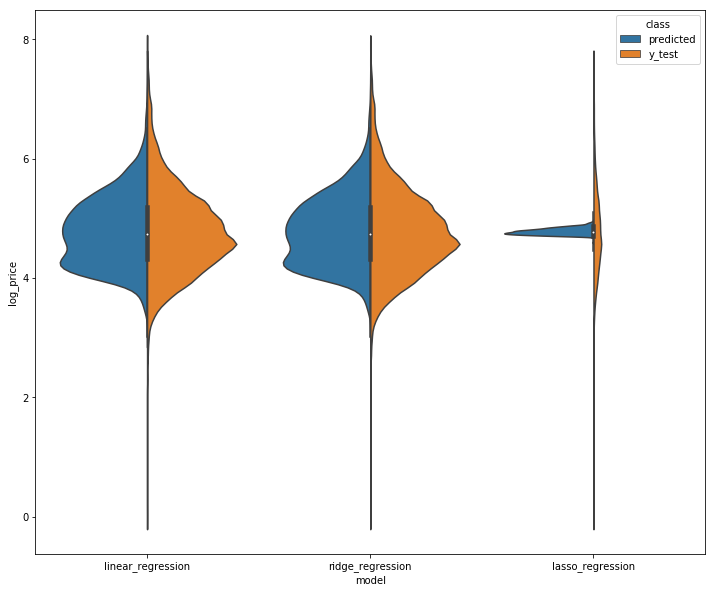

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
sns.violinplot(x='model',
               y='log_price',
               hue='class',
               data=yf,
               split=True,
               ax=ax)

plt.savefig('figures/eta_pre_violin.png')
plt.show()